# See how to change the underlying coordinates_AIS file to fix issues on land

In [111]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cmocean
import cartopy.crs as ccrs

Load files

In [112]:
folder='/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/'

global_grid = xr.open_dataset(f'{folder}domcfg_eORCA025_v3.nc')
coord_AIS   = xr.open_dataset(f'{folder}coordinates_AIS.nc')
domcfg_old  = xr.open_dataset(f'{folder}domain_cfg-old.nc')
domcfg_new  = xr.open_dataset(f'{folder}domain_cfg-20231025.nc')

Variables with issues in coordinates_AIS: nav_lat, e2f, e2v, e2u, e2t, e1f, e1v, e1u, e1t, gphif, gphiv, gphiu, gphit
--> domcfg_old contains all of the issue areas filled, so could try to just fill the problem areas with the values from it.

# For now, instead of fixing coordinates_AIS.nc let's just manually fix the domain_cfg file

Need to fix both in the Antarctic and the Strait of Magellan and coastal fjords. 

**Note that this fix should work fine for my current use, but for the coupled model, I will need to fix the underlying coordinates file because the bathymetry is otherwise messed up**

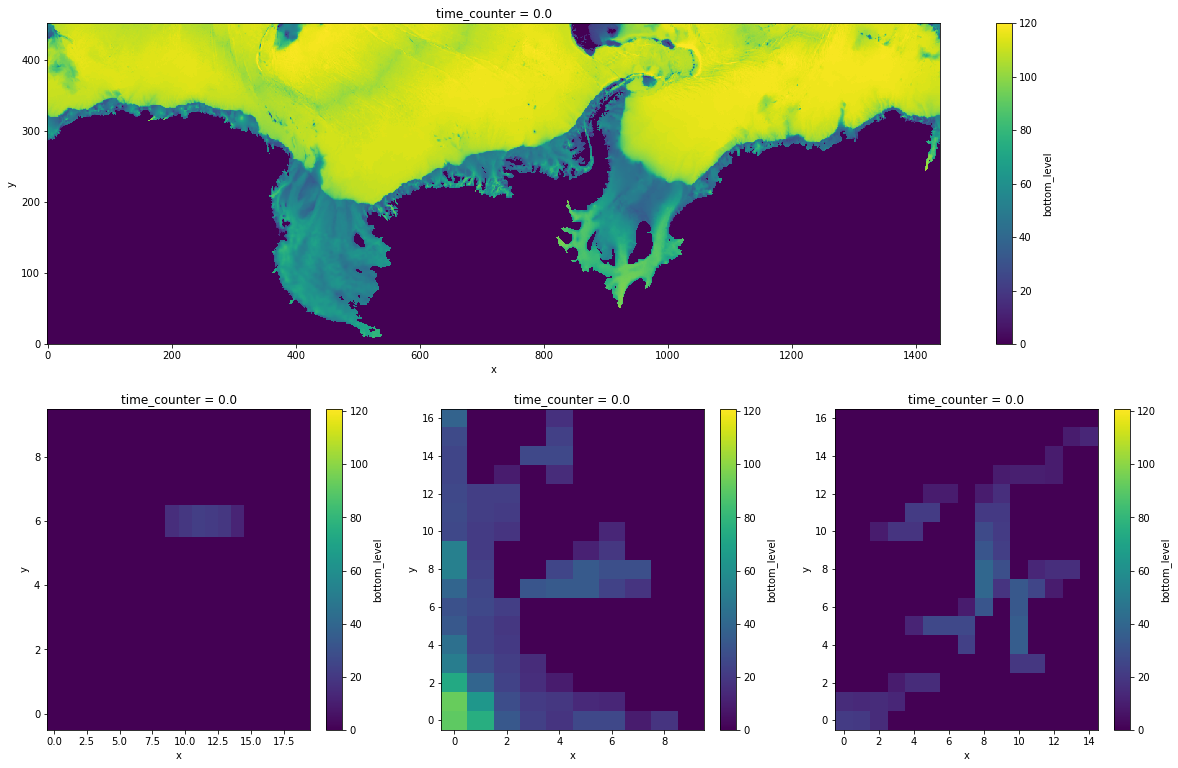

In [114]:
fig = plt.figure(figsize=(20,13))
gs  = fig.add_gridspec(2,3)
ax1 = fig.add_subplot(gs[0,:]); ax2 = fig.add_subplot(gs[1,0]);
ax3 = fig.add_subplot(gs[1,1]); ax4 = fig.add_subplot(gs[1,2]);

domcfg_new.bottom_level.plot(ax=ax1)
domcfg_new.bottom_level.isel(x=slice(120,140), y=slice(180,190)).plot(ax=ax2, vmin=0, vmax=121)
domcfg_new.bottom_level.isel(x=slice(845,855), y=slice(435,-1)).plot(ax=ax3, vmin=0, vmax=121)
domcfg_new.bottom_level.isel(x=slice(857,872), y=slice(422,439)).plot(ax=ax4, vmin=0, vmax=121)

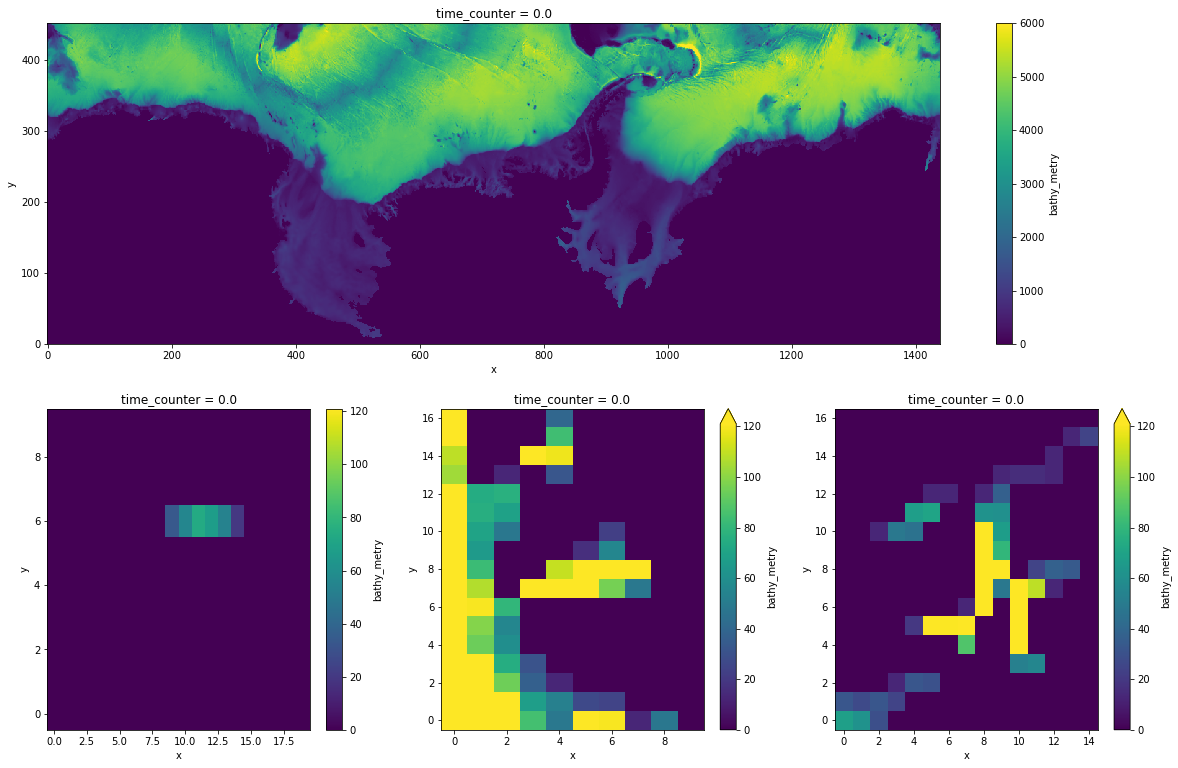

In [115]:
fig = plt.figure(figsize=(20,13))
gs  = fig.add_gridspec(2,3)
ax1 = fig.add_subplot(gs[0,:]); ax2 = fig.add_subplot(gs[1,0]);
ax3 = fig.add_subplot(gs[1,1]); ax4 = fig.add_subplot(gs[1,2]);

domcfg_new.bathy_metry.plot(ax=ax1)
domcfg_new.bathy_metry.isel(x=slice(120,140), y=slice(180,190)).plot(ax=ax2, vmin=0, vmax=121)
domcfg_new.bathy_metry.isel(x=slice(845,855), y=slice(435,-1)).plot(ax=ax3, vmin=0, vmax=121)
domcfg_new.bathy_metry.isel(x=slice(857,872), y=slice(422,439)).plot(ax=ax4, vmin=0, vmax=121)

So, need to fill x=128:135, y=186 with zeros to remove lakes in Antarctica

Need to fill x=848:850, y=447:453 and x=848:853, y=441:446 with zeros to close the fjords.

And need to fill x=856:867, y=426:438 and x=863:872, y=424:431, with zeros to close the strait of magellan

In [116]:
domcfg_filled = domcfg_new.copy()

In [120]:
bottom_array = domcfg_filled.bottom_level.values
bathy_array  = domcfg_filled.bathy_metry.values

bottom_array[0, 186, slice(128,135)] = 0
bottom_array[0, slice(447,453), slice(848,850)] = 0
bottom_array[0, slice(441,446), slice(848,853)] = 0
bottom_array[0, slice(426,438), slice(856,870)] = 0
bottom_array[0, slice(424,431), slice(863,872)] = 0

bathy_array[0, 186, slice(128,135)] = 0
bathy_array[0, slice(447,453), slice(848,850)] = 0
bathy_array[0, slice(441,446), slice(848,853)] = 0
bathy_array[0, slice(426,438), slice(856,870)] = 0
bathy_array[0, slice(424,431), slice(863,872)] = 0

In [124]:
domcfg_filled['bottom_level'] = (('time_counter', 'y', 'x'), bottom_array)
domcfg_filled['bathy_metry'] = (('time_counter', 'y', 'x'), bathy_array.astype('float'))

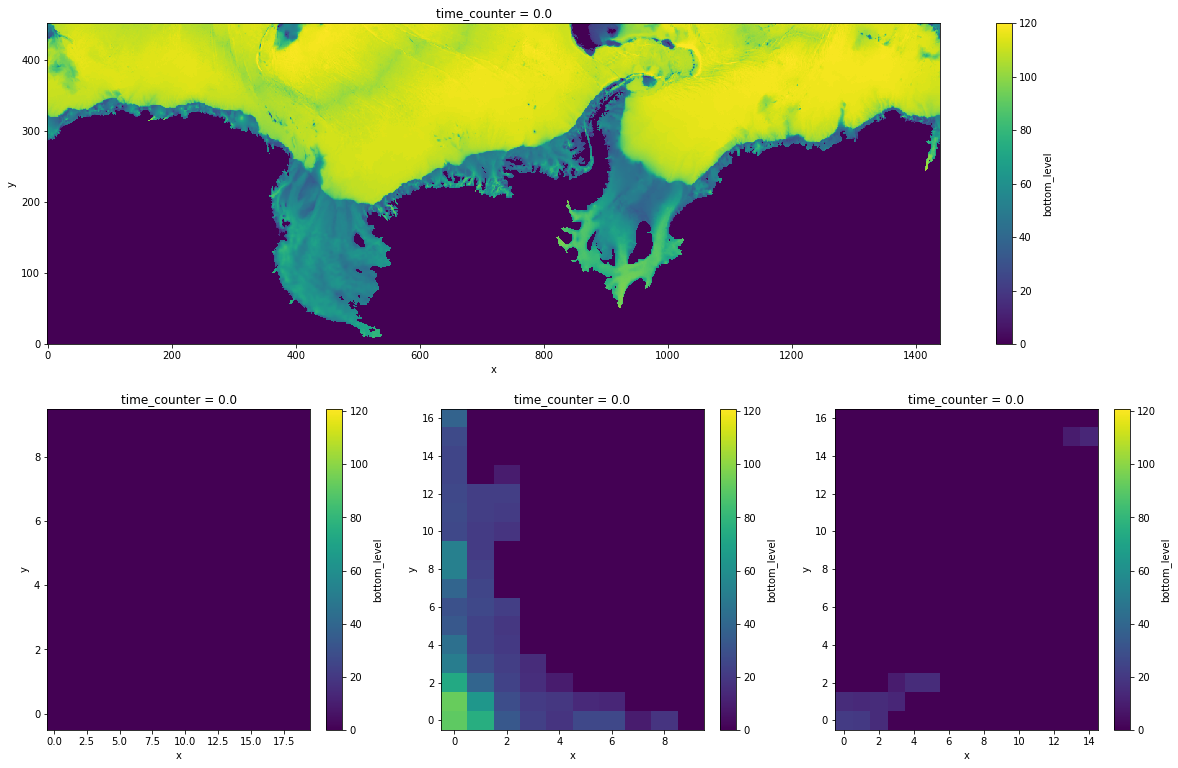

In [125]:
fig = plt.figure(figsize=(20,13))
gs  = fig.add_gridspec(2,3)
ax1 = fig.add_subplot(gs[0,:]); ax2 = fig.add_subplot(gs[1,0]);
ax3 = fig.add_subplot(gs[1,1]); ax4 = fig.add_subplot(gs[1,2]);

domcfg_filled.bottom_level.plot(ax=ax1)
domcfg_filled.bottom_level.isel(x=slice(120,140), y=slice(180,190)).plot(ax=ax2, vmin=0, vmax=121)
domcfg_filled.bottom_level.isel(x=slice(845,855), y=slice(435,-1)).plot(ax=ax3, vmin=0, vmax=121)
domcfg_filled.bottom_level.isel(x=slice(857,872), y=slice(422,439)).plot(ax=ax4, vmin=0, vmax=121)

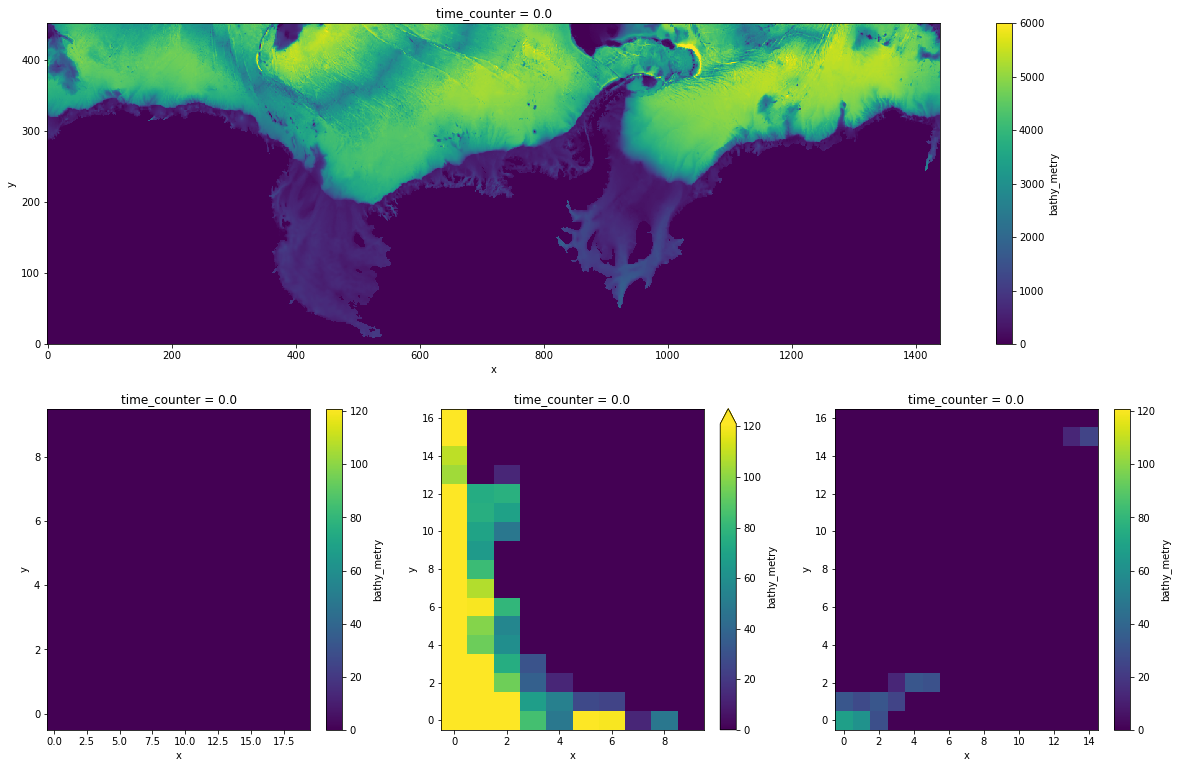

In [126]:
fig = plt.figure(figsize=(20,13))
gs  = fig.add_gridspec(2,3)
ax1 = fig.add_subplot(gs[0,:]); ax2 = fig.add_subplot(gs[1,0]);
ax3 = fig.add_subplot(gs[1,1]); ax4 = fig.add_subplot(gs[1,2]);

domcfg_filled.bathy_metry.plot(ax=ax1)
domcfg_filled.bathy_metry.isel(x=slice(120,140), y=slice(180,190)).plot(ax=ax2, vmin=0, vmax=121)
domcfg_filled.bathy_metry.isel(x=slice(845,855), y=slice(435,-1)).plot(ax=ax3, vmin=0, vmax=121)
domcfg_filled.bathy_metry.isel(x=slice(857,872), y=slice(422,439)).plot(ax=ax4, vmin=0, vmax=121)

In [127]:
domcfg_filled.to_netcdf(f'{folder}domain_cfg-20231025-filledlakes.nc')

## do the same thing for the mesh_mask file

In [162]:
mesh_new = xr.open_dataset(f'{folder}mesh_mask-20231025.nc')
mesh_filled = mesh_new.copy()

# 2D:
for var in ['bathy_metry', 'mbathy', 'misf', 'mhw', 'hw', 'tmaskutil', 'umaskutil', 'vmaskutil']:
    array_to_fill = mesh_new[var].values
    array_to_fill[0, 186, slice(128,135)] = 0
    array_to_fill[0, slice(447,453), slice(848,850)] = 0
    array_to_fill[0, slice(441,446), slice(848,853)] = 0
    array_to_fill[0, slice(426,438), slice(856,870)] = 0
    array_to_fill[0, slice(424,431), slice(863,872)] = 0

    mesh_filled[var] = (('time_counter', 'y', 'x'), array_to_fill)

# 3D:
for var in ['tmask', 'umask', 'vmask', 'fmask']:
    array_to_fill = mesh_new[var].values
    array_to_fill[0, :, 186, slice(128,135)] = 0
    array_to_fill[0, :, slice(447,453), slice(848,850)] = 0
    array_to_fill[0, :, slice(441,446), slice(848,853)] = 0
    array_to_fill[0, :, slice(426,438), slice(856,870)] = 0
    array_to_fill[0, :, slice(424,431), slice(863,872)] = 0

    mesh_filled[var] = (('time_counter', 'z', 'y', 'x'), array_to_fill)

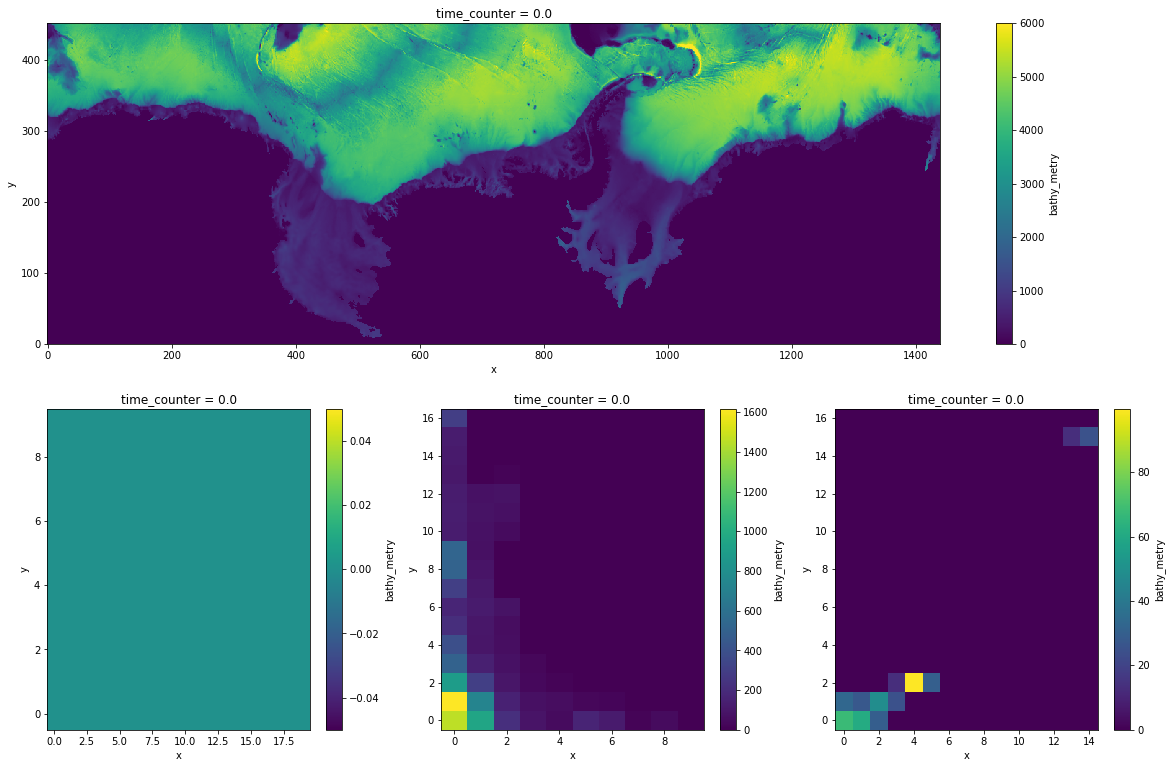

In [164]:
fig = plt.figure(figsize=(20,13))
gs  = fig.add_gridspec(2,3)
ax1 = fig.add_subplot(gs[0,:]); ax2 = fig.add_subplot(gs[1,0]);
ax3 = fig.add_subplot(gs[1,1]); ax4 = fig.add_subplot(gs[1,2]);

var=mesh_filled.bathy_metry #.isel(nav_lev=0)

var.plot(ax=ax1)
var.isel(x=slice(120,140), y=slice(180,190)).plot(ax=ax2)
var.isel(x=slice(845,855), y=slice(435,-1)).plot(ax=ax3)
var.isel(x=slice(857,872), y=slice(422,439)).plot(ax=ax4)

In [165]:
mesh_filled.to_netcdf(f'{folder}mesh_mask-20231025-filledlakes.nc')